In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import joblib

In [30]:
# Cargamos el dataset
df_raw = pd.read_csv("cm1.csv")
df = df_raw.copy()
df.head()

,McCabe's line count of code,"McCabe ""cyclomatic complexity”","McCabe ""essential complexity”","McCabe ""design complexity”",Halstead total operators + operands,"Halstead ""volume”","Halstead ""program length”","Halstead ""difficulty”","Halstead ""intelligence”","Halstead ""effort”",...,Halstead's line count,Halstead's count of lines of comments,Halstead's count of blank,lineslOCodeAndComment,unique operators,unique operands,total operators,total operands,branchCount of the flow graph,defects
0,1.1,1.4,1.4,1.4,1.3,1.30,1.30,1.30,1.30,1.30,...,2,2,2,2,1.2,1.2,1.2,1.2,1.4,False
1,1.0,1.0,1.0,1.0,1.0,1.00,1.00,1.00,1.00,1.00,...,1,1,1,1,1.0,1.0,1.0,1.0,1.0,True
2,24.0,5.0,1.0,3.0,63.0,309.13,0.11,9.50,32.54,2936.77,...,1,0,6,0,15.0,15.0,44.0,19.0,9.0,False
3,20.0,4.0,4.0,2.0,47.0,215.49,0.06,16.00,13.47,3447.89,...,0,0,3,0,16.0,8.0,31.0,16.0,7.0,False
4,24.0,6.0,6.0,2.0,72.0,346.13,0.06,17.33,19.97,5999.58,...,0,0,3,0,16.0,12.0,46.0,26.0,11.0,False


In [31]:
# Preprocesado de datos

# Convertimos los nombres de las columnas a otros más usables
mapa_total = {
    # McCabe
    "McCabe's line count of code":       "loc",
    'McCabe "cyclomatic complexity"':    "complexity",
    
    # Halstead (Radon las calcula todas)
    "Halstead total operators + operands": "h_length",      # N (N1 + N2)
    'Halstead "volume"':                   "h_volume",      # V
    'Halstead "difficulty"':               "h_difficulty",  # D
    'Halstead "effort"':                   "h_effort",      # E
    "Halstead's time estimator":           "h_time",        # T
    
    # Conteos Operadores/Operandos
    "unique operators":                    "h_uniq_op",     # h1
    "unique operands":                     "h_uniq_opnd",   # h2
    "total operators":                     "h_total_op",    # N1
    "total operands":                      "h_total_opnd",  # N2
    
    # Comentarios y Blancos
    "Halstead's count of lines of comments": "comments",
    "Halstead's count of blank":           "blank",
    
    # Target
    "defects":                             "has_bug"
}


df.columns = df.columns.str.strip().str.replace('”', '"') # Arreglar comillas raras
df = df.rename(columns=mapa_total)

# Seleccionamos solo las columnas que nos interesan (las que tienen nombre en el mapa)
columnas_validas = list(mapa_total.values())
# Filtramos si alguna columna no existe en el CSV descargado
columnas_finales = [c for c in columnas_validas if c in df.columns]

df = df[columnas_finales]

# Limpieza de datos (To Numeric)
for col in df.columns:
    if col != 'has_bug':
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Limpieza target (True/False -> 1/0)
if df['has_bug'].dtype == 'object':
    df['has_bug'] = df['has_bug'].apply(lambda x: 1 if str(x).lower() in ['true', 'yes'] else 0)
else:
    df['has_bug'] = df['has_bug'].astype(int)

df = df.dropna()

Generando Matriz de Correlación...


Text(0.5, 1.0, 'Matriz de Correlación: Métricas de Código vs Defectos')

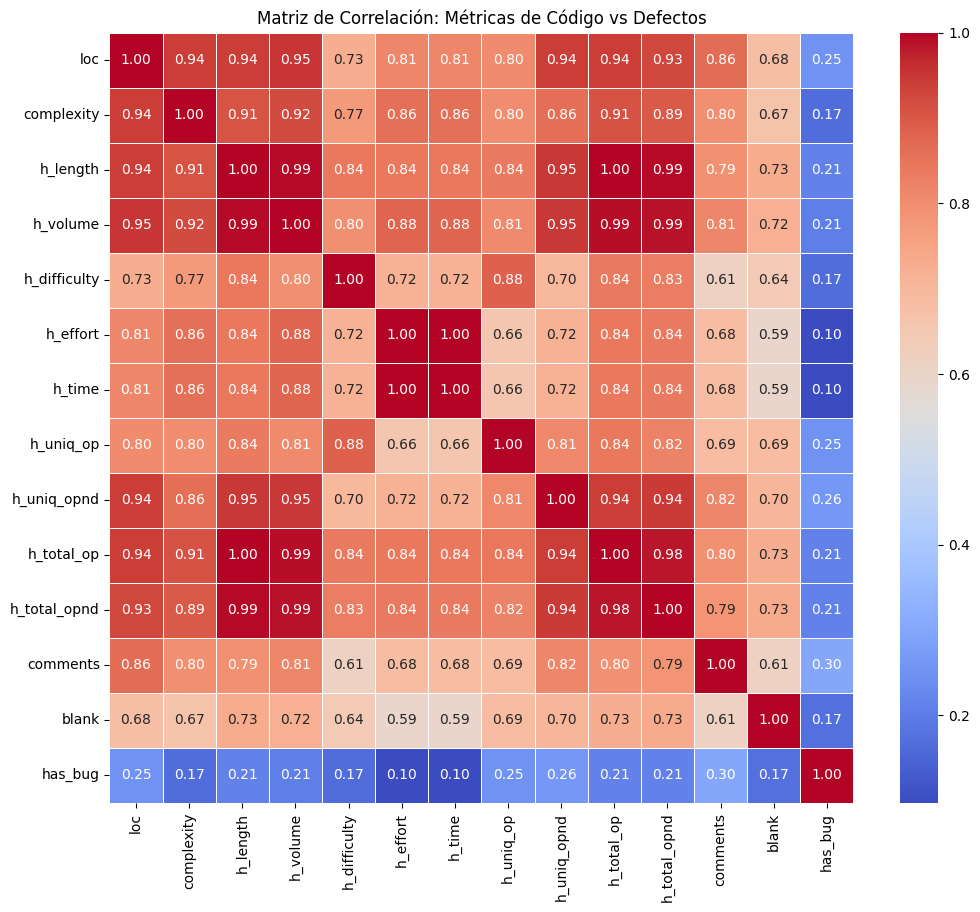

In [32]:
# Generación de matriz de correlación
print("Generando Matriz de Correlación...")

plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()

# Dibujamos el heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación: Métricas de Código vs Defectos")

In [33]:
target = 'has_bug'
features = [
    'loc',           # Representante de TAMAÑO (tiene correlación 0.25 con bugs, mejor que volume)
    'complexity',    # Representante de FLUJO (McCabe)
    'h_uniq_op',     # Representante de VOCABULARIO (tiene 0.25, muy bueno)
    'comments',      # Representante de DOCUMENTACIÓN (¡Ojo! tiene 0.30, la más alta con bugs)
    'h_effort'       # Representante de ESFUERZO COGNITIVO (Halstead)
]

X = df[features]
y = df[target]

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

datos_modelo = {
    "model": model,
    "features": features
}

print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.89      0.91        96
           1       0.88      0.94      0.91        84

    accuracy                           0.91       180
   macro avg       0.91      0.91      0.91       180
weighted avg       0.91      0.91      0.91       180



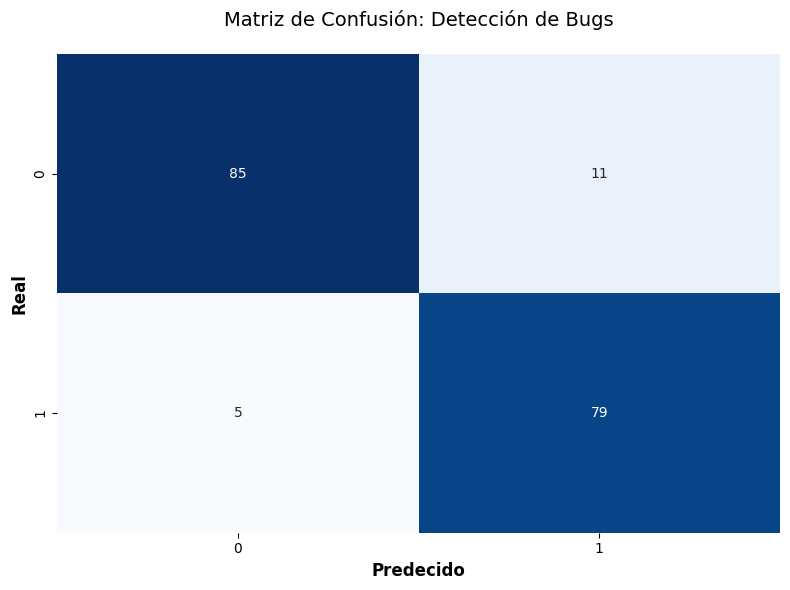

In [ ]:
# 1. Obtenemos las predicciones (si no las tenías guardadas)
y_pred = model.predict(X_test)

# 2. Calculamos la matriz matemática
cm = confusion_matrix(y_test, y_pred)

# 3. Pintamos el gráfico (Heatmap)
plt.figure(figsize=(8, 6))

# Usamos Seaborn para que quede bonito
# fmt='d' es para que ponga números enteros (no científicos)
# cmap='Blues' usa tonos azules (muy corporativo/NASA)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

# Etiquetas y Títulos
plt.xlabel('Predecido', sfontsize=12, fontweight='bold')
plt.ylabel('Real', fontsize=12, fontweight='bold')
plt.title('Matriz de Confusión: Detección de Bugs', fontsize=14, pad=20)

# 4. Guardar y Mostrar
plt.tight_layout()
plt.savefig("matriz_confusion_final.png", dpi=300) # Alta resolución para el Word/PDF
plt.show()

In [35]:
joblib.dump(datos_modelo, "modelo_nasa_full.pkl")

['modelo_nasa_full.pkl']